In [1]:
import sys

sys.path.append("..")

In [2]:
from common.utility import show_implementation
from module.utility import show_images
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In the previous chapter about [segmentation](./segmentation.ipynb), we identify regions based on intensity and colours.

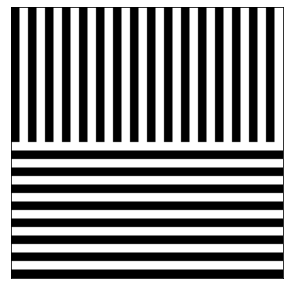

In [3]:
length = 32
hrange = np.arange(length // 2).reshape((-1, 1))
vrange = np.arange(length).reshape((-1, 1))
firstRegion = (np.repeat(vrange, length // 2, axis=1) % 2).T * 255
secondRegion = (np.repeat(hrange, length, axis=1) % 2 == 0) * 255
two_texture_image = np.vstack((firstRegion, secondRegion))

two_texture_image = np.repeat(two_texture_image, 5, axis=0)
two_texture_image = np.repeat(two_texture_image, 5, axis=1)

f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
ax.imshow(two_texture_image, cmap="gray", vmin=0, vmax=255)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

However, consider the image above.
From our perspective, we can clearly see two separate regions based on which way the stripes are oriented.
Thus, we can segment it as a top-half and a bottom-half.
Notice that our previous method of using only intensity or colour is insufficient in segmenting the two regions, as they have identical intensity/colour.

Secondly, note that using an edge detector also fails to uniquely pick out the regions.


This perceived difference in regions is attributed to the differences in **texture** in the two regions.

## Image texture
A texture is a pattern with a repeating element.
These repetitions can contain some variations.

## Motivation
We analyze textures for the following reasons:

For visual perception:
* Determine the material properties
* Extract appearance cues, such as shape, boundaries and textures

For computer vision:
* Another level of representation of an image, above colours, edges and filters

## Identifying Texture

In [4]:
from module.convolve import convolve
from module.kernel import dog, Orientation

From the gradients and edges chapter, we learnt that [DoG filters](./gradients_and_edges.ipynb#dog) are able to detect horizontal and vertical edges.

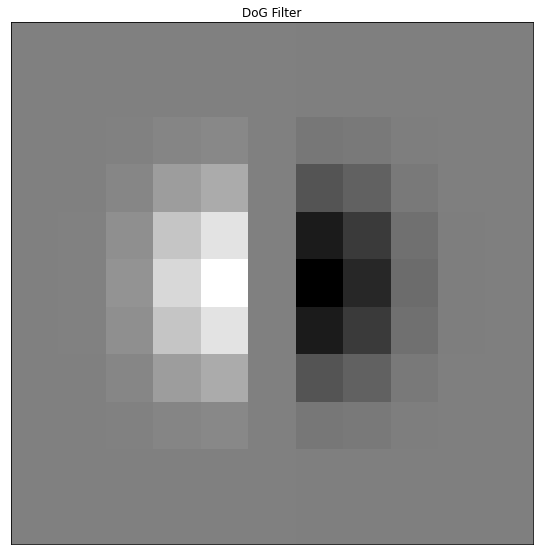

In [5]:
h_filter = dog(11, orientation=Orientation.horizontal)
show_images((h_filter, "DoG Filter", True))

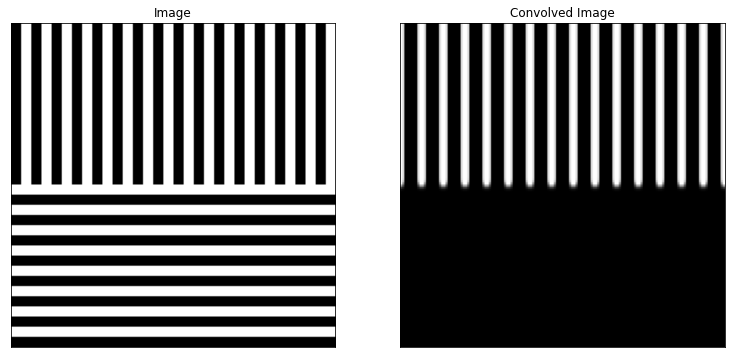

In [6]:
response = convolve(two_texture_image, h_filter, pad=False)
show_images((two_texture_image, "Image"), (response, "Convolved Image"))

Indeed, convolving the horizontal DoG filter creates regions of high response in the top half of the image, while giving no response in the bottom half.

However, notice that "pixel-level" information is insufficient to determine the texture of the region.
This is evident by the observation that even though all pixels in the top half corresponds to the same texture, some pixels have high response and some pixels have low response, as shown by the banding.

Thus, a natural way to identify the texture of the region is to compute the average response over a window. 
Note that taking an average is equivalent to using a box filter on the response.

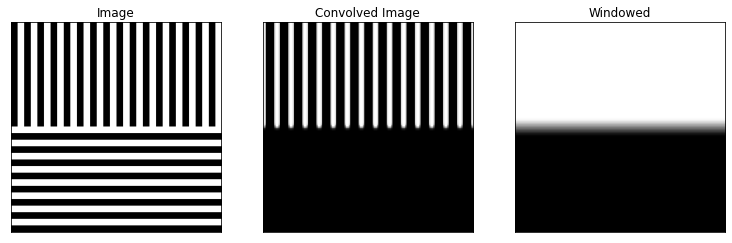

In [7]:
from module.kernel import box_filter

WINDOW_SIZE = 10

windowed = convolve(response, box_filter(WINDOW_SIZE), pad=False, clip=False)
show_images(
    (two_texture_image, "Image"),
    (response, "Convolved Image"),
    (windowed, "Windowed", True),
)

Indeed, with the average response in the window, we can detect regions with the "vertical stripes" texture.

We can do similarly for the "horizontal stripes" texture

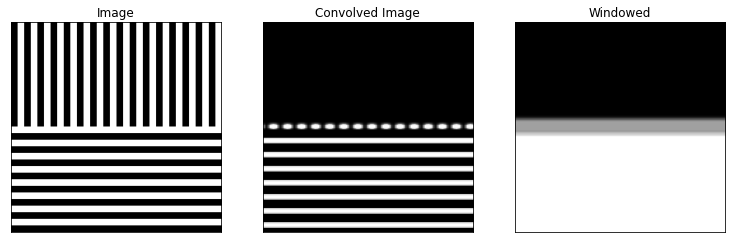

In [8]:
v_filter = dog(11, orientation=Orientation.vertical)

response = convolve(two_texture_image, v_filter, pad=False)
windowed = convolve(response, box_filter(WINDOW_SIZE), pad=False, clip=False)
show_images(
    (two_texture_image, "Image"),
    (response, "Convolved Image"),
    (windowed, "Windowed", True),
)

Notice that the boundary between texture generally gives a noisy response.

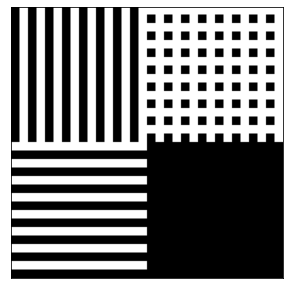

In [9]:
length = 16
hrange = np.arange(length).reshape((-1, 1))
vrange = np.arange(length).reshape((-1, 1))
first_region = (np.repeat(vrange, length, axis=1) % 2).T * 255
second_region = (np.repeat(hrange, length, axis=1) % 2 == 0) * 255
box_region = np.where(first_region + second_region > 0, 255, 0)
empty_region = np.zeros(first_region.shape)

left_half = np.vstack((first_region, second_region))
right_half = np.vstack((box_region, empty_region))
four_texture_image = np.hstack((left_half, right_half))

four_texture_image = np.repeat(four_texture_image, 5, axis=0)
four_texture_image = np.repeat(four_texture_image, 5, axis=1)

f = plt.figure(figsize=(5, 5))
ax = f.add_subplot(111)
ax.imshow(four_texture_image, cmap="gray", vmin=0, vmax=255)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

Suppose we were to analyze the texture of the above image.
There are clearly 4 different texture in the image.
How do we differentiate the texture using our above approach?

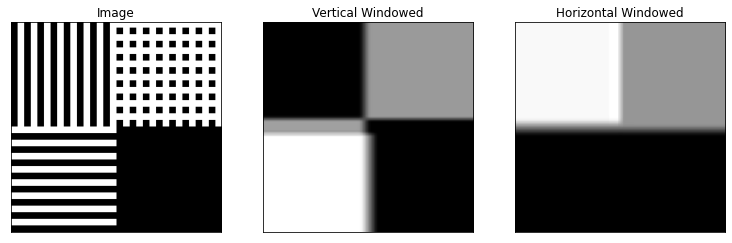

In [10]:
v_response, h_response = convolve(four_texture_image, v_filter, pad=False), convolve(
    four_texture_image, h_filter, pad=False
)
v_windowed, h_windowed = convolve(
    v_response, box_filter(WINDOW_SIZE), pad=False, clip=False
), convolve(h_response, box_filter(WINDOW_SIZE), pad=False, clip=False)

show_images(
    (four_texture_image, "Image"),
    (v_windowed, "Vertical Windowed", True),
    (h_windowed, "Horizontal Windowed", True),
)

Notice that each region corresponds to the following characteristics for each windowed response.

| Texture | Vertical Windowed Response | Horizontal Windowed Response |
| :--- | :---: | :---: |
| Horizontal stripes | Low | High |
| Vertical stripes | High | Low |
| Boxes | Medium | Medium |
| Flat | Low | Low |

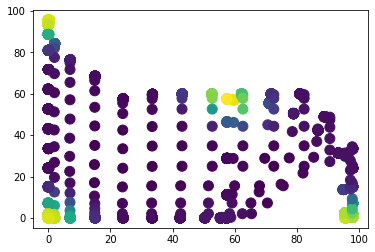

In [11]:
from scipy.stats import gaussian_kde

x, y = h_windowed.ravel(), v_windowed.ravel()
xy = np.vstack((x, y))
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

As we can see, there are 4 dense clusters, which fits our assumed clustering of the textures.

## Determining Texture Window


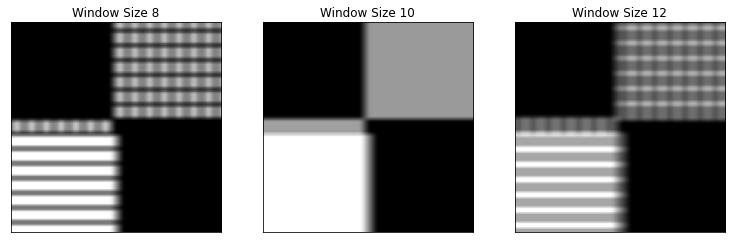

In [12]:
v_response = convolve(four_texture_image, v_filter, pad=False)
windows = [
    convolve(v_response, box_filter(w), pad=False, clip=False) for w in (8, 10, 12)
]

show_images([(w, f"Window Size {i}", True) for i, w in zip((8, 10, 12), windows)])

Notice that the response is rather dependent on the window size.
Choosing too small a window will fail to capture enough pixel statistics to determine the texture.
Choosing too large a window will fail to differentiate the textures.
To determine the correct window size, we can look for scales where the distribution of the clusters do not change much.

## Filter Banks
In our current approach, we used a horizontal and a vertical DoG filter to obtain a 2-dimensional feature to represent the texture in a window.
We can generalize this to apply multiple filters.
This set of filters is known as a **filter bank**.

Hence, using $d$ filters, we will have a $d$-dimensional feature vector, which can be used to differentiate the texture.

For example, we can have vertical filters ($0^\circ$), horizontal filters ($180^\circ$), and also multiple filters at different angles.
To generate these filters of different angles easily, we can use **Gabor Filter**

### Gabor Filter

#### 1D Gabor Filter


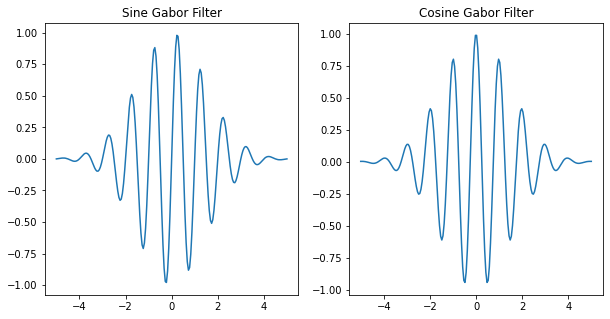

In [13]:
f = plt.figure(figsize=(10, 5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.title.set_text("Sine Gabor Filter")
ax2.title.set_text("Cosine Gabor Filter")

xs = np.linspace(-5, 5, 200)

sigma, omega = 1.5, 1

ax1.plot(xs, np.exp(-(xs**2) / (2 * sigma**2)) * np.sin(2 * np.pi * omega * xs))
ax2.plot(xs, np.exp(-(xs**2) / (2 * sigma**2)) * np.cos(2 * np.pi * omega * xs))
plt.show()

A Gabor filter is basically a sinusoid contained in an Gaussian envelope.


#### 2D Gabor Filter

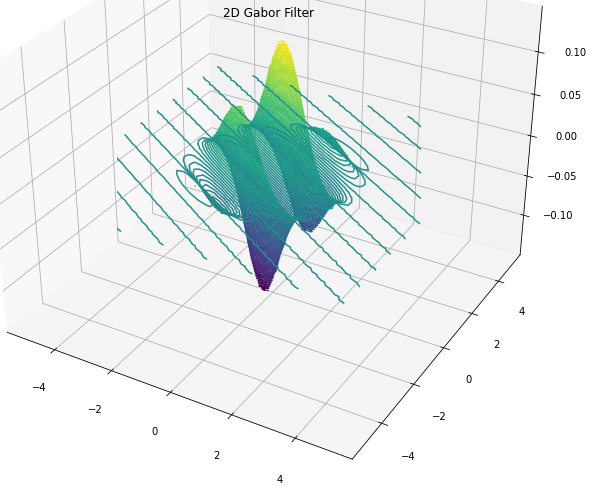

In [14]:
xs, ys = np.linspace(-5, 5), np.linspace(-5, 5)
xs, ys = np.meshgrid(xs, ys)


sigma, omega, lamb, phi = 1, 1, 1.5, 0

fp = 1 / (2 * np.pi * sigma**2)
sp = np.exp(-(xs**2 + ys**2) / (2 * sigma**2))
lp = np.sin((2 * np.pi * (xs * np.cos(omega) + ys * np.sin(omega))) / lamb + phi)

zs = fp * sp * lp

fig = plt.figure(figsize=(12, 24))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.contour3D(xs, ys, zs, 100, cmap="viridis")
ax.dist = 5
ax.set_title("2D Gabor Filter")
plt.show()

Equivalently, we can visualize the Gabor filter as a 2D image.

In [15]:
from module.kernel import gabor

show_implementation(gabor)

def gabor(size, sigma=1,omega=1, lamb=1, phi=0):
    assert size % 2 == 1
    
    xs, ys = np.linspace(-5, 5, size), np.linspace(-5, 5, size)
    xs, ys = np.meshgrid(xs, ys)

    fp = 1/(2 * np.pi * sigma**2)
    sp = np.exp(- (xs ** 2 + ys**2)/ (2 * sigma**2))
    lp = np.sin(2 * np.pi * (xs * np.cos(omega) + ys * np.sin(omega))/lamb + phi)

    return fp * sp * lp


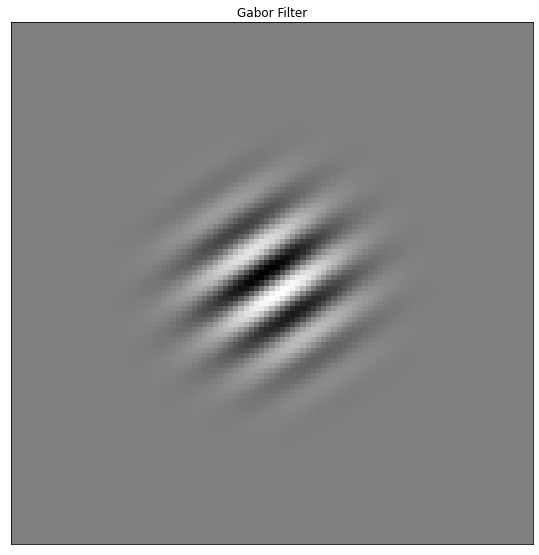

In [16]:
show_images((gabor(101, sigma=1, omega=1), "Gabor Filter", True))

##### Effects of parameters

$\sigma$ affects the amount of exponential decay.
Thus, higher $\sigma$ will lead to a larger envelope and also a stronger filter response.

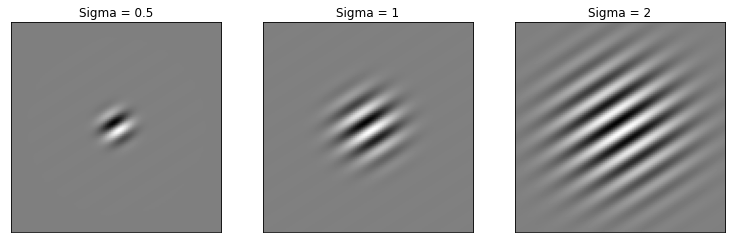

In [17]:
show_images([(gabor(101, sigma=s), f"Sigma = {s}", True) for s in (0.5, 1, 2)])

$\omega$ affects the orientation of the filter.

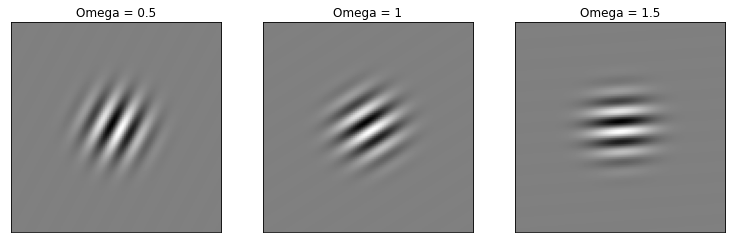

In [18]:
show_images([(gabor(101, omega=o), f"Omega = {o}", True) for o in (0.5, 1, 1.5)])

$\lambda$ affects the frequency of the sinusoid.
Thus, higher $\lambda$ will change the frequency of "folds" within the filter.

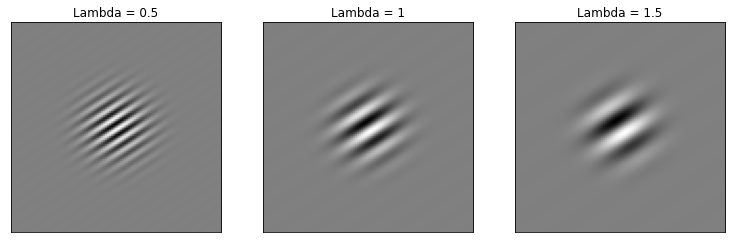

In [19]:
show_images([(gabor(101, lamb=l), f"Lambda = {l}", True) for l in (0.5, 1, 1.5)])

$\phi$ affects the phase of the sinusoid.
Thus, different $\phi$ will lead to different initial banding value.
Notice that all the filters below have the same frequency sinusoid, just that they have different phases.

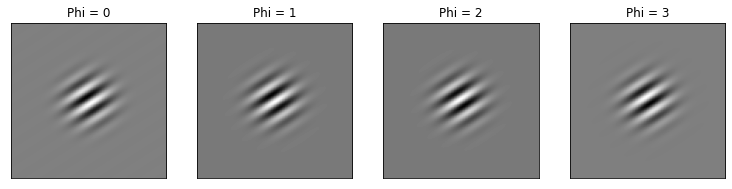

In [20]:
show_images([(gabor(101, phi=p), f"Phi = {p}", True) for p in (0, 1, 2, 3)])

##### Approximate Derivatives
Notice that at small scale, Gabor filters can approximate our [DoG](./gradients_and_edges.ipynb#dog) and [LoG](./gradients_and_edges.ipynb#log) filters.

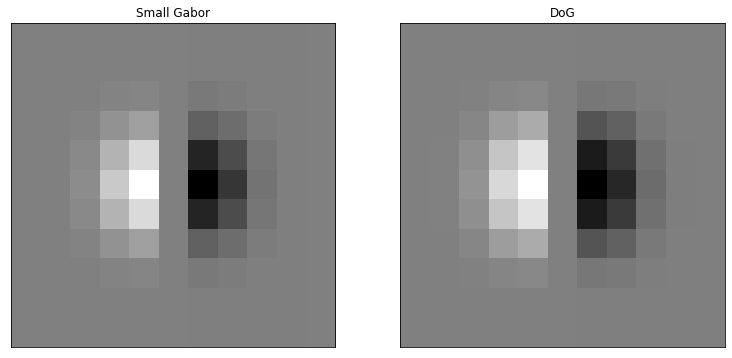

In [21]:
show_images(
    (gabor(11, sigma=1.2, lamb=10, omega=np.pi), "Small Gabor", True),
    (dog(11), "DoG", True),
)

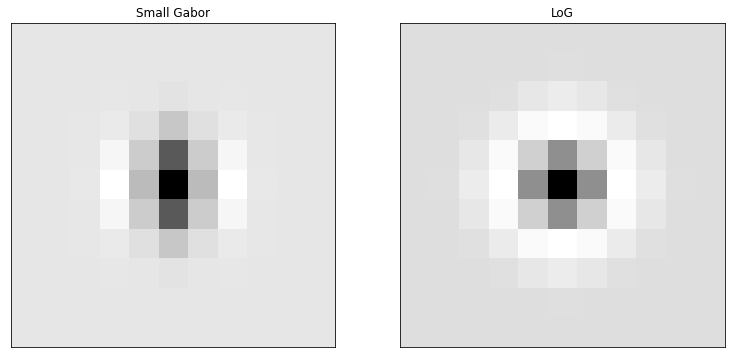

In [22]:
from module.kernel import log

show_images(
    (gabor(11, sigma=1, lamb=5, omega=0, phi=1.5 * np.pi), "Small Gabor", True),
    (log(11), "LoG", True),
)

Hence, using 2D Gabor filters provides us a convenient way to generated different (edge detecting) filters at different orientations and sizes.
Therefore, they are a good tool to use for creating our filter bank.

To augment our banks to detect blobs, usually we include some blob detecting filters in our filter bank, such as Gaussian filters.

## Textons

A **texton** characterizes a texture by replacing each pixel with an integer which represents the type of texture of that pixel.


### Computing Textons
#### Training
1. Apply filter bank to training images
2. Cluster in the feature space and store the cluster centers
3. This forms our texton dictionary

#### Testing
1. Filter the test image with the same filter bank to obtain a feature vector for each pixel
2. Assign each pixel to the nearest cluster based on its corresponding feature vector

As we have established previously, texture is determined by the responses of the pixels within some window.
Thus, to determine the texture from textons, we need to look at the distribution of textons across the region of interest. 
That is to say, we are interested in the histogram of texton in the region.

Given on some sample textures, we can conclude that regions in the image with similar textures will produce similar histograms to that of the sample textures.

## Perceived Boundaries
It is interesting to note that when humans determine there to be a boundary between two objects in an image, the factor that separate the two objects is mostly the difference in texture.
We can identify a white cat against a white background because we can perceive that there is a difference between the the texture of the cat and that of the wall; not because of any strong edges between the cat and the wall, neither because of difference in colour.

### Identifying the Boundaries
To identify the texture boundary:
1. Collect a circle area of the image
2. Split the circle into two halves
3. Compute the difference in texture between the two halves by comparing the texton histogram
4. Try all possible orientations
5. If there exists a orientation that gives that largest difference and passes some threshold
    * Then that is the boundary in that area
    * Otherwise there is no boundary in the area